## QUANT_GAN

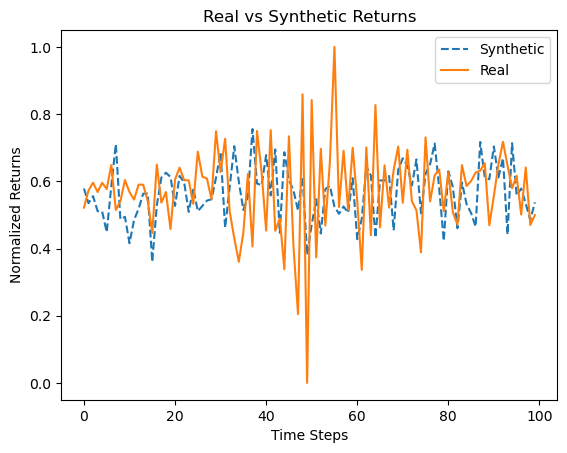

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from pathlib import Path
import pandas as pd

# 1. Prepare Data
def load_stock_data(file_name="nvidia_2020_2021.csv"):
    # Get the path relative to this script's location
    base_path = Path.cwd()
    file_path = base_path / "data" / file_name

    if not file_path.exists():
        raise FileNotFoundError(f"{file_path} not found. Please pull the repo with the data folder.")

    # Read CSV with multi-index header (2 rows)
    df = pd.read_csv(file_path, header=[0,1], index_col=0, parse_dates=True)

    if df.empty or df.isnull().all().all():
        raise ValueError(f"File {file_name} is empty or contains only NaNs.")

    # Access the 'Close' price for 'NVDA' ticker (second level)
    df['log_price'] = np.log(df[('Close', 'NVDA')])
    df['log_return'] = df['log_price'].diff()
    df.dropna(inplace=True)  # Drop NaN values
    dates = df.index.to_list()

    scaler = MinMaxScaler()
    scaled_returns = scaler.fit_transform(df[['log_return']])  # Note: Double brackets for 2D input
    
    return scaled_returns, dates, scaler  # Return tensor directly
    

def create_sequences(data, seq_len):
    sequences = []
    for i in range(len(data) - seq_len):
        sequences.append(data[i:i+seq_len])
    return torch.stack(sequences)  # Creates tensor directly
    

# 2. Define TCN Block
class TemporalBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, dilation, padding):
        super().__init__()
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size,
                               stride=stride, padding=padding, dilation=dilation)
        self.relu = nn.ReLU()
        self.net = nn.Sequential(self.conv1, self.relu)

    def forward(self, x):
        return self.net(x)

# 3. Define Generator and Discriminator
class Generator(nn.Module):
    def __init__(self, input_dim, hidden_dim, seq_len):
        super().__init__()
        self.tcn = TemporalBlock(input_dim, hidden_dim, kernel_size=2, stride=1, dilation=1, padding=1)
        self.fc = nn.Linear(hidden_dim * (seq_len + 1), seq_len)

    def forward(self, x):
        x = x.permute(0, 2, 1)  # (batch, features, seq_len)
        x = self.tcn(x)
        x = x.contiguous()
        x = x.reshape(x.size(0), -1)
        x = self.fc(x)
        return x.unsqueeze(-1)

class Discriminator(nn.Module):
    def __init__(self, input_dim, hidden_dim, seq_len):
        super().__init__()
        self.tcn = TemporalBlock(input_dim, hidden_dim, kernel_size=2, stride=1, dilation=1, padding=1)
        self.fc = nn.Linear(hidden_dim * (seq_len + 1), 1)

    def forward(self, x):
        x = x.permute(0, 2, 1)  # (batch, features, seq_len)
        x = self.tcn(x)
        x = x.reshape(x.size(0), -1)  # Use reshape instead of view
        x = self.fc(x)
        return x

# 4. Training Setup
input_dim = 1
hidden_dim = 64
seq_len = 100
lr = 0.001
batch_size = 64
epochs = 5000

real_data, dates, scaler = load_stock_data()
real_data_tensor = torch.tensor(real_data, dtype=torch.float32)  # Convert NumPy array to PyTorch tensor
sequences = create_sequences(real_data_tensor, seq_len)
sequences = sequences.float()  # Ensure the tensor is of type float

# Models
generator = Generator(input_dim, hidden_dim, seq_len)
discriminator = Discriminator(input_dim, hidden_dim, seq_len)

# Optimizers
g_optimizer = optim.Adam(generator.parameters(), lr=lr)
d_optimizer = optim.Adam(discriminator.parameters(), lr=lr)

# Loss
bce = nn.BCEWithLogitsLoss()

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
generator.to(device)
discriminator.to(device)
sequences = sequences.to(device)

# Training Loop
for epoch in range(epochs):
    for i in range(0, len(sequences), batch_size):
        real_seq = sequences[i:i+batch_size]
        batch_size_curr = real_seq.size(0)

        # Train Discriminator
        z = torch.randn(batch_size_curr, seq_len, input_dim).to(device)
        fake_seq = generator(z)

        d_real = discriminator(real_seq)
        d_fake = discriminator(fake_seq.detach())

        d_loss_real = bce(d_real, torch.ones_like(d_real))
        d_loss_fake = bce(d_fake, torch.zeros_like(d_fake))
        d_loss = d_loss_real + d_loss_fake

        d_optimizer.zero_grad()
        d_loss.backward()
        d_optimizer.step()

        # Train Generator
        d_fake = discriminator(fake_seq)
        g_loss = bce(d_fake, torch.ones_like(d_fake))

        g_optimizer.zero_grad()
        g_loss.backward()
        g_optimizer.step()

# Generate Synthetic Data
generator.eval()
z = torch.randn(1, seq_len, input_dim).to(device)
synthetic_data = generator(z).detach().cpu().numpy().squeeze()

# Plot
plt.plot(synthetic_data, label="Synthetic", linestyle="--")
plt.plot(sequences[0].cpu().numpy().squeeze(), label="Real", linestyle="-")
plt.legend()
plt.xlabel("Time Steps")
plt.ylabel("Normalized Returns")
plt.title("Real vs Synthetic Returns")
plt.show()



Basic Statistics Comparison:
       Real Returns  Synthetic Returns
count    100.000000         100.000000
mean       0.003521           0.000442
std        0.048509           0.029813
min       -0.204567          -0.073720
25%       -0.019606          -0.019533
50%        0.006974           0.004194
75%        0.030337           0.018000
max        0.158454           0.069701


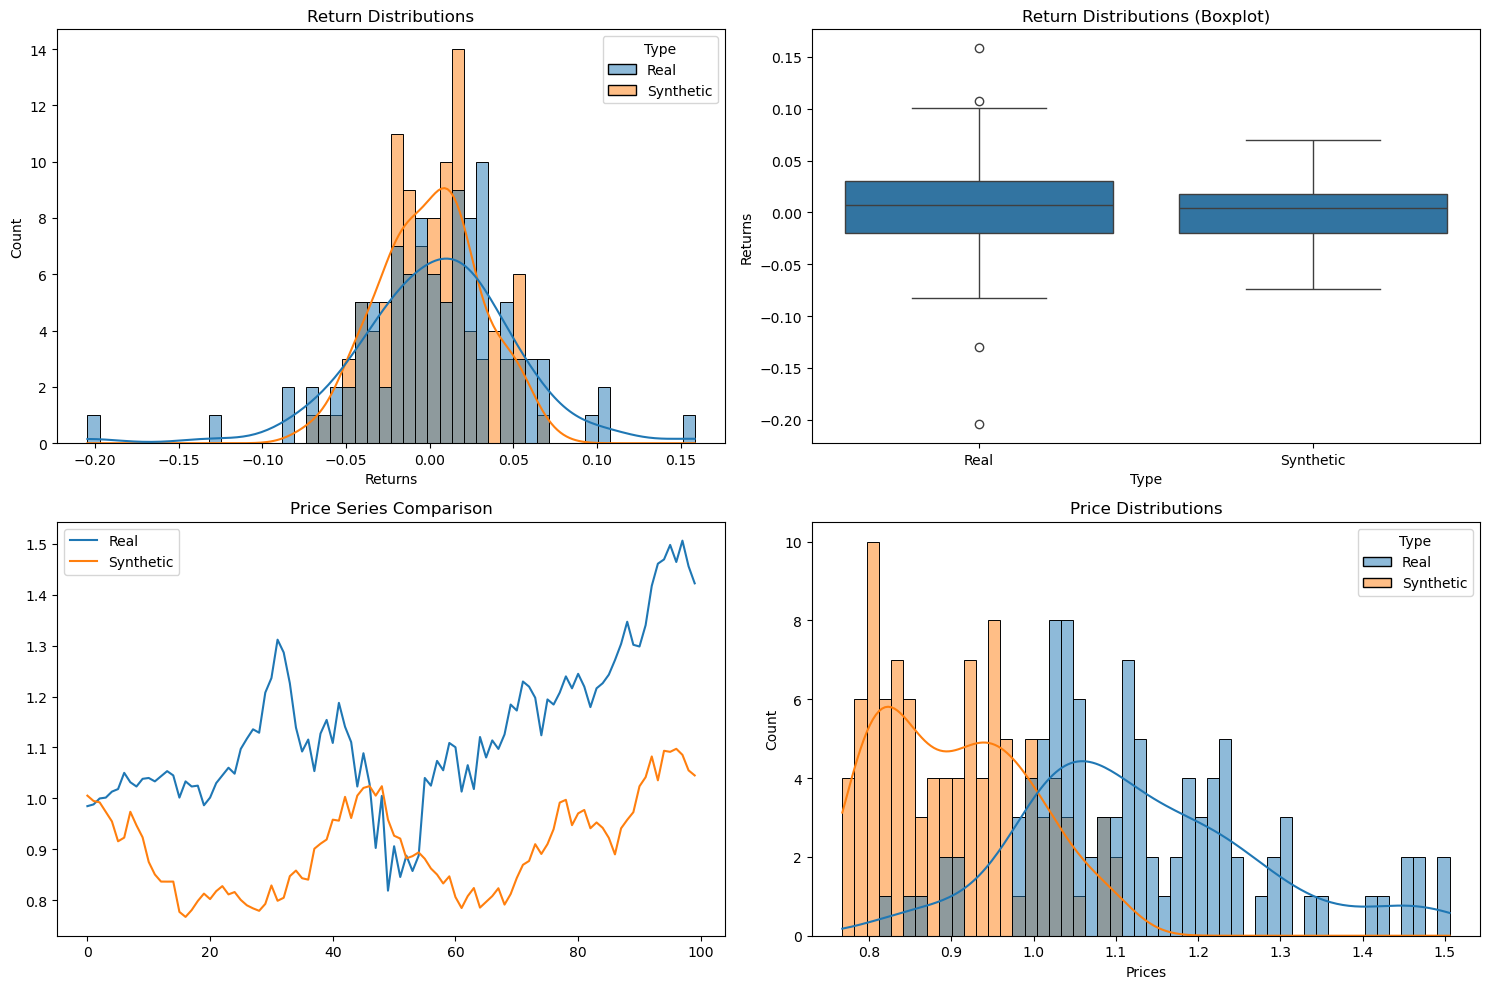


Statistical Tests:
Kolmogorov-Smirnov Test: stat=0.1600, p-value=0.1548
T-test: stat=0.5409, p-value=0.5892


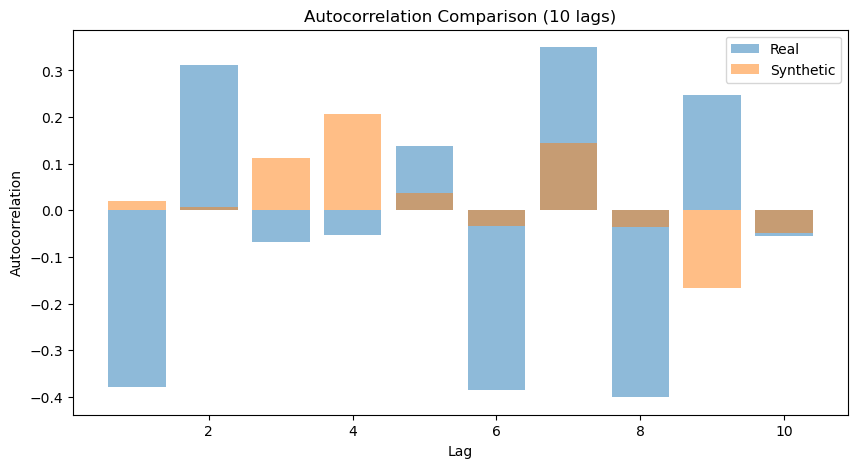

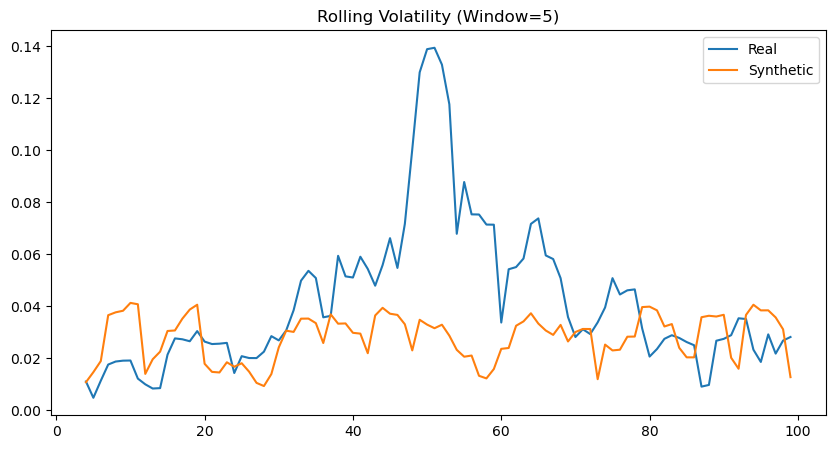

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns

def statistical_comparison(real_data, synthetic_data, scaler):
    """
    Compare real and synthetic data statistically
    
    Args:
        real_data: Raw real sequences from create_sequences() (shape: [n_sequences, seq_len])
        synthetic_data: Generated synthetic data (shape: [1, seq_len])
        scaler: The MinMaxScaler used during training
    """
    # Inverse transform the normalized data
    real_returns = scaler.inverse_transform(real_data.cpu().numpy().reshape(-1, 1)).flatten()
    synthetic_returns = scaler.inverse_transform(synthetic_data.reshape(-1, 1)).flatten()
    
    # Convert returns to prices for additional analysis
    real_prices = np.exp(np.cumsum(real_returns))
    synthetic_prices = np.exp(np.cumsum(synthetic_returns))
    
    # Create DataFrame for visualization
    df_real = pd.DataFrame({
        'Returns': real_returns,
        'Prices': real_prices,
        'Type': 'Real'
    })
    
    df_synthetic = pd.DataFrame({
        'Returns': synthetic_returns,
        'Prices': synthetic_prices,
        'Type': 'Synthetic'
    })
    
    df = pd.concat([df_real, df_synthetic])
    
    # 1. Basic Statistics Comparison
    print("\nBasic Statistics Comparison:")
    print(pd.DataFrame({
        'Real Returns': df_real['Returns'].describe(),
        'Synthetic Returns': df_synthetic['Returns'].describe()
    }))
    
    # 2. Distribution Visualization
    plt.figure(figsize=(15, 10))
    
    plt.subplot(2, 2, 1)
    sns.histplot(data=df, x='Returns', hue='Type', kde=True, bins=50)
    plt.title('Return Distributions')
    
    plt.subplot(2, 2, 2)
    sns.boxplot(data=df, x='Type', y='Returns')
    plt.title('Return Distributions (Boxplot)')
    
    plt.subplot(2, 2, 3)
    plt.plot(real_prices, label='Real')
    plt.plot(synthetic_prices, label='Synthetic')
    plt.title('Price Series Comparison')
    plt.legend()
    
    plt.subplot(2, 2, 4)
    sns.histplot(data=df, x='Prices', hue='Type', kde=True, bins=50)
    plt.title('Price Distributions')
    
    plt.tight_layout()
    plt.show()
    
    # 3. Statistical Tests
    print("\nStatistical Tests:")
    
    # Kolmogorov-Smirnov test
    ks_stat, ks_p = stats.ks_2samp(real_returns, synthetic_returns)
    print(f"Kolmogorov-Smirnov Test: stat={ks_stat:.4f}, p-value={ks_p:.4f}")
    
    # T-test
    t_stat, t_p = stats.ttest_ind(real_returns, synthetic_returns)
    print(f"T-test: stat={t_stat:.4f}, p-value={t_p:.4f}")
    
    # Autocorrelation comparison
    def autocorr(x, lag=10):
        return [x.autocorr(l) for l in range(1, lag+1)]
    
    real_acf = autocorr(pd.Series(real_returns))
    synth_acf = autocorr(pd.Series(synthetic_returns))
    
    plt.figure(figsize=(10, 5))
    plt.bar(range(1, 11), real_acf, alpha=0.5, label='Real')
    plt.bar(range(1, 11), synth_acf, alpha=0.5, label='Synthetic')
    plt.title('Autocorrelation Comparison (10 lags)')
    plt.xlabel('Lag')
    plt.ylabel('Autocorrelation')
    plt.legend()
    plt.show()
    
    # 4. Volatility Clustering
    def rolling_volatility(x, window=5):
        return pd.Series(x).rolling(window).std().dropna()
    
    real_vol = rolling_volatility(real_returns)
    synth_vol = rolling_volatility(synthetic_returns)
    
    plt.figure(figsize=(10, 5))
    plt.plot(real_vol, label='Real')
    plt.plot(synth_vol, label='Synthetic')
    plt.title('Rolling Volatility (Window=5)')
    plt.legend()
    plt.show()

# Usage with your existing code:
if __name__ == "__main__":
    # After your training code...
    generator.eval()
    z = torch.randn(1, seq_len, input_dim).to(device)
    synthetic_data = generator(z).detach().cpu().numpy().squeeze()
    
    # Select a real sequence for comparison
    real_sequence = sequences[0].cpu().numpy().squeeze()
    
    # Perform statistical comparison
    statistical_comparison(sequences[0], synthetic_data, scaler)